## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [18]:
import os
from tensorflow import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [23]:

def build_mlp(input_shape, output_units=10, num_neuron=[1024,512,256,128],after=True):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    if after == True:
        for i, n_units in enumerate(num_neuron):
            if i == 0:
                x = keras.layers.Dense(units=n_units,activation='relu')(input_layer)
                x = keras.layers.BatchNormalization()(x)
            else:
                x = keras.layers.Dense(units=n_units,activation='relu')(x)
                x = keras.layers.BatchNormalization()(x)
    else:
        for i, n_units in enumerate(num_neuron):
            if i == 0:
                x = keras.layers.BatchNormalization()(input_layer)
                x = keras.layers.Dense(units=n_units,activation='relu')(x)
            else:
                x = keras.layers.BatchNormalization()(x)
                x = keras.layers.Dense(units=n_units,activation='relu')(x)
    out = keras.layers.Dense(units=output_units,activation='softmax')(x)
    
    model = keras.models.Model(inputs=[input_layer],outputs=[out])
    return model

In [27]:
"""Code Here
設定超參數
"""
BATCH_SIZE = [2,16,32,128,256]
LEARNING_RATE = 1e-3
EPOCHS = 50
MOMENTUM = 0.95
AFTER = [True,False]

In [28]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for batch, after in itertools.product(BATCH_SIZE,AFTER):
    keras.backend.clear_session()
    model = build_mlp(input_shape=x_train.shape[1:], after=after)
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE,momentum=MOMENTUM,nesterov=True)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    model.fit(x_train, y_train,
              epochs=EPOCHS,
              batch_size=batch,
              validation_data=(x_test, y_test),
              shuffle=True)
    
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    if after == True :
        layer = 'after'
    else:
        layer = 'before'
    tag = "BN %s layer, Batch_size=%s " % (str(layer),str(batch))
    
    results[tag] = {'train_loss':train_loss,
                    'train_acc':train_acc,
                    'valid_acc':valid_acc,
                    'valid_loss':valid_loss} 

Epoch 1/50
25000/25000 [==============================] - 72s 3ms/step - loss: 2.3189 - accuracy: 0.1425 - val_loss: 2.6257 - val_accuracy: 0.1701
Epoch 2/50
25000/25000 [==============================] - 72s 3ms/step - loss: 2.2582 - accuracy: 0.1546 - val_loss: 3.1731 - val_accuracy: 0.1695
Epoch 3/50
25000/25000 [==============================] - 71s 3ms/step - loss: 2.2581 - accuracy: 0.1524 - val_loss: 3.0224 - val_accuracy: 0.1724
Epoch 4/50
25000/25000 [==============================] - 71s 3ms/step - loss: 2.2539 - accuracy: 0.1523 - val_loss: 5.7068 - val_accuracy: 0.1706
Epoch 5/50
25000/25000 [==============================] - 71s 3ms/step - loss: 2.2599 - accuracy: 0.1471 - val_loss: 8.3984 - val_accuracy: 0.1587
Epoch 6/50
25000/25000 [==============================] - 71s 3ms/step - loss: 2.2530 - accuracy: 0.1549 - val_loss: 9.8700 - val_accuracy: 0.1662
Epoch 7/50
25000/25000 [==============================] - 70s 3ms/step - loss: 2.2462 - accuracy: 0.1604 - val_loss: 1

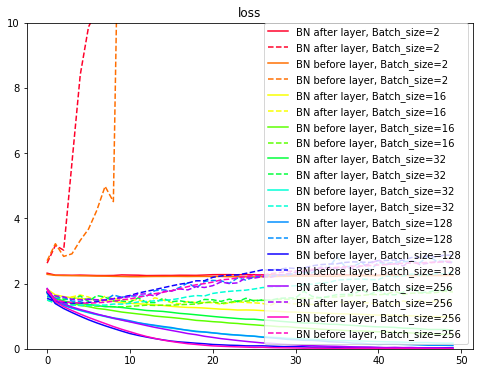

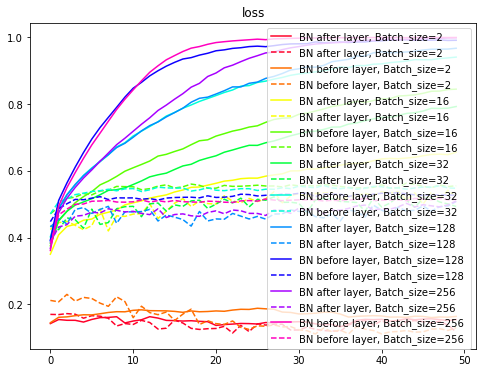

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 10

cm = plt.get_cmap('gist_rainbow')
cNorm = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'],'-',color=color_bar[i],label=cond)
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'],'--',color=color_bar[i],label=cond)
plt.ylim([0, 10])
plt.title('loss')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'],'-',color=color_bar[i],label=cond)
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'],'--',color=color_bar[i],label=cond)
plt.title('accuracy')
plt.legend()
plt.show()
